# Занятие №15

## Нейронные сети

- сверточные (конволюционные) нейронные сети (CNN) - компьютерное зрение, классификация изображений
- рекуррентные нейронные сети (RNN) - распознования рукописного текста, обработка естественного языка
- генеративные состязательные сети (GAN) - создание художественных, музыкальных произведений
- многослойный перцептрон - простейший тип НС

In [1]:
# Данная сеть способная сложить 2+2 или другие небольшие значения

w0 = 0.9987879
w1 = 1.0264927
w2 = 0.1417504
w3 = -0.8950311
w4 = 0.88046944
w5 = 0.7524377
w6 = 0.794296
w7 = 1.1687347
w8 = 0.2406084

b0 = -0.00070612
b1 = -0.05846002
b2 = -0.00055442
b3 = -0.00000929


def relu(x):
    return max(0, x)


def predict(x1, x2):
    h1 = (x1 * w0) + (x2 * w1) + b0
    h2 = (x1 * w2) + (x2 * w3) + b1
    h3 = (x1 * w4) + (x2 * w5) + b2

    y = (relu(h1) * w6) + (relu(h2) * w7) + (relu(h3) * w8) + b3
    return y


print(predict(2, 2))
print(predict(1, 2))

4.002423351122503
2.9972417740968083


In [3]:
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

(224, 224, 3)
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[('n02113978', 'Mexican_hairless', np.float32(0.42397577)), ('n02091032', 'Italian_greyhound', np.float32(0.059329282)), ('n02454379', 'armadillo', np.float32(0.03529858)), ('n02124075', 'Egyptian_cat', np.float32(0.03177905)), ('n01877812', 'wallaby', np.float32(0.030067679))]


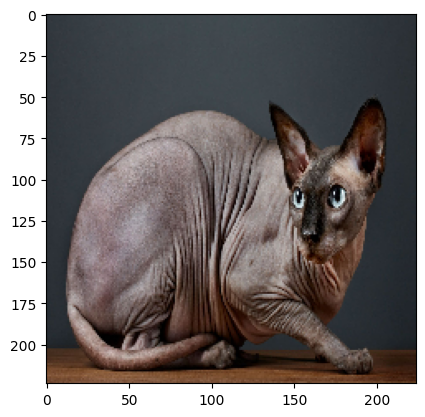

In [19]:
img_path = r".\cat.png"
img = image.load_img(img_path, target_size=(224, 224))

import numpy as np

img_array = image.img_to_array(img)
print(img_array.shape)

img_batch = np.expand_dims(img_array, axis=0)
print(img_batch.shape)

from tensorflow.keras.applications.resnet50 import preprocess_input

img_processed = preprocess_input(img_batch)

from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50()

prediction = model.predict(img_processed)

from tensorflow.keras.applications.resnet50 import decode_predictions

print(decode_predictions(prediction, top=5)[0])


plt.imshow(img)
plt.show()

## Нейросеть, которая отличает котов и собак

1. Организация данных
2. Построим пайплайн подготовки
3. Аугментация данных. Обогащение набора
4. Определение модели. Заморозка коэффициентов. Алгоритм оптимизатора. Метрика оценки
5. Обучение модели -> итерации -> пока метрика не станет приемлимой.
6. Сохранить модель

In [42]:
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from tensorflow.keras.preprocessing import image

TRAIN_DATA_DIR = r".\dogs-vs-cats-redux-kernels-edition\train_data"
VALIDATION_DATA_DIR = r".\dogs-vs-cats-redux-kernels-edition\val_data"
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

train_datagen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
)

val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=12345,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)

from tensorflow.keras.models import Model


def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation="relu")(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    prediction = Dense(NUM_CLASSES, activation="softmax")(custom_model)
    return Model(inputs=input, outputs=prediction)


from tensorflow.keras.optimizers import Adam


model = model_maker()
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["acc"])

import math

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)

model.fit(
    train_generator,
    steps_per_epoch=num_steps,
    epochs=10,
    validation_data=val_generator,
    validation_steps=num_steps,
)

print(val_generator.class_indices)

model.save("my_model.keras")

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


C:\Users\vov4i\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - acc: 0.5202 - loss: 1.1749 - val_acc: 0.9380 - val_loss: 0.1694
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - acc: 0.8780 - loss: 0.2859 - val_acc: 0.9620 - val_loss: 0.1081
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - acc: 0.9334 - loss: 0.1699 - val_acc: 0.9700 - val_loss: 0.0766
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - acc: 0.9464 - loss: 0.1285 - val_acc: 0.9740 - val_loss: 0.0664
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - acc: 0.9533 - loss: 0.1240 - val_acc: 0.9760 - val_loss: 0.0613
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - acc: 0.9570 - loss: 0.1016 - val_acc: 0.9780 - val_loss: 0.0573
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - acc: 0.9775 - loss: 0.0747 - val_acc: 0.9800 - val_loss: 0.0521
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - acc: 0.9527 - loss: 0.1157 - val_acc: 0.9800 - val_loss: 0.0491
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - acc: 0.9587 - loss: 0.1124 - val_acc: 

## Проверка модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
[[0.00441606 0.99558395]]


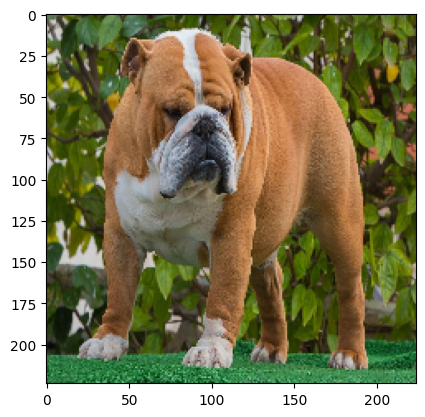

In [47]:
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model(
    r"my_model.keras"
)

img_path = r".\dog.jpg"
img = image.load_img(img_path, target_size=(224, 224))

import numpy as np

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

img_processed = preprocess_input(img_batch)

prediction=model.predict(img_processed)
print(prediction)

plt.imshow(img)
plt.show()

# ЗАДАЧА НА ПРАКТИКУ №2 (со звездочкой)
## Написать нейросеть, которая будет складывать два небольших числа (от 0 до 10)

In [21]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Генерация пары чисел от 0 до 10
num = np.random.randint(0, 11, size=(10000, 2))
# Сумма пары чисел
summa = num.sum(axis=1)

# Нормализация чисел (от 0 до 1). Максимальное число 10
X = num.astype("float32") / 10.0
# Нормализация суммы (от 0 до 1). Максимальная сумма 20
y = summa.astype("float32") / 20.0

model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(2,)),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)

from tensorflow.keras.optimizers import Adam

model.compile(loss="mse", optimizer=Adam(), metrics=["mae"])

import math

batch_size = 64
num_steps = math.ceil(float(10000) / batch_size)

model.fit(
    X,
    y,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.2,
    steps_per_epoch=num_steps,
)

# model.save("Нейросеть(сумма 2-ух чисел до 10).keras")


def predict_sum(a, b):
    # Обратное преобразование чисел
    input_data = np.array([[a, b]]) / 10.0
    prediction = (
        model.predict(input_data)[0][0] * 20.0
    )  # Обратное преобразование суммы чисел
    return round(prediction, 3)


print(f"Сумма чисел 1 и 0 равен {predict_sum(1, 0)}")
print(f"Сумма чисел 7 и 8 равен {predict_sum(7, 8)}")
print(f"Сумма чисел 10 и 9 равен {predict_sum(10, 9)}")

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0244 - mae: 0.0918 - val_loss: 1.6582e-05 - val_mae: 0.0033
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1356e-05 - mae: 0.0027 - val_loss: 4.6558e-06 - val_mae: 0.0018
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6897e-06 - mae: 0.0016 - val_loss: 2.3703e-06 - val_mae: 0.0012
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1628e-06 - mae: 0.0012 - val_loss: 1.7175e-06 - val_mae: 0.0010
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6636e-06 - mae: 0.0010 - val_loss: 1.3774e-06 - val_mae: 9.0303e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3098e-06 - mae: 8.8374e-04 - val_loss: 1.5739e-06 - val_mae: 9.9042e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1134e-06 - mae: 8.0053e-04 - val_loss: 9.3573e-07 - val_mae: 7.3150e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9773e-07 - mae: 7.6744e-04 - val_loss: 8